In [1]:
# Imports and CUDA/CPU
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data Loading and Preprocessing
def load_data(filename):
    with open(filename, 'r') as f:
        text = f.read()
    words = text.replace('\n', '<eos>').split()
    return words

train_words = load_data('ptb_data/ptb.train.txt')
valid_words = load_data('ptb_data/ptb.valid.txt')
test_words = load_data('ptb_data/ptb.test.txt')

from collections import Counter
counter = Counter(train_words)
vocab = sorted(counter.keys())
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

def words_to_indices(words, word_to_idx):
    return [word_to_idx[word] for word in words if word in word_to_idx]

train_data = words_to_indices(train_words, word_to_idx)
valid_data = words_to_indices(valid_words, word_to_idx)
test_data = words_to_indices(test_words, word_to_idx)

In [3]:
# Dataset and DataLoader
class PTBDataset(Dataset):
    def __init__(self, data, seq_len=35):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return (len(self.data) - 1) // self.seq_len

    def __getitem__(self, index):
        start_index = index * self.seq_len
        end_index = start_index + self.seq_len
        seq = self.data[start_index:end_index]
        target = self.data[start_index+1:end_index+1]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

def get_data_loader(data, batch_size=20, seq_len=35):
    dataset = PTBDataset(data, seq_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [4]:
# Model Definition
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=200, num_layers=2, dropout=0.5, model_type='LSTM'):
        super(RNNModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.encoder = nn.Embedding(vocab_size, hidden_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
        self.decoder.weight = self.encoder.weight
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        emb = self.encoder(input)
        emb = nn.functional.dropout(emb, p=self.dropout, training=self.training)
        output, hidden = self.rnn(emb, hidden)
        output = nn.functional.dropout(output, p=self.dropout, training=self.training)
        decoded = self.decoder(output.reshape(-1, self.hidden_size))
        return decoded, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if self.model_type == 'LSTM':
            return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [5]:
# Utility functions
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def evaluate_model(model, data_loader, criterion, config):
    model.eval()
    total_loss = 0.0
    hidden = model.init_hidden(config.batch_size)

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)
            loss = criterion(output, targets.reshape(-1))
            total_loss += loss.item()

    return torch.exp(torch.tensor(total_loss / len(data_loader)))

In [6]:
# Training function (incl. saving)
def train_model(model, train_loader, valid_loader, test_loader, config):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)
    model.to(device)

    train_perplexities = []
    valid_perplexities = []
    test_perplexities = []
    best_valid_perplexity = float('inf')
    best_test_perplexity = float('inf')

    for epoch in range(1, config.epochs + 1):
        model.train()
        total_loss = 0.0
        hidden = model.init_hidden(config.batch_size)

        for batch, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()

            # Detach hidden states to prevent backpropagating through entire history
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)
            loss = criterion(output, targets.reshape(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            optimizer.step()
            total_loss += loss.item()

        train_perplexity = torch.exp(torch.tensor(total_loss / len(train_loader)))
        train_perplexities.append(train_perplexity.item())

        valid_perplexity = evaluate_model(model, valid_loader, criterion, config)
        valid_perplexities.append(valid_perplexity.item())

        test_perplexity = evaluate_model(model, test_loader, criterion, config)
        test_perplexities.append(test_perplexity.item())
        
        scheduler.step(valid_perplexity)

        if valid_perplexity < best_valid_perplexity:
            best_valid_perplexity = valid_perplexity
            torch.save(model.state_dict(), f'best_model_{config.cell_type}_dropout{config.dropout}.pth')
            print(f'Model saved to best_model_{config.cell_type}_dropout{config.dropout}.pth')
            best_test_perplexity = test_perplexity

        print(f'Epoch {epoch}, Train Perplexity: {train_perplexity.item():.2f}, '
              f'Valid Perplexity: {valid_perplexity.item():.2f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.4f}')

    return train_perplexities, valid_perplexities, best_test_perplexity

In [7]:
# Training config
class TrainConfig:
    def __init__(self, cell_type='LSTM', hidden_size=200, num_layers=2, dropout=0.5,
                 learning_rate=5.0, weight_decay=1e-5, clip=0.5, epochs=50, batch_size=20, seq_len=35):
        self.cell_type = cell_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip = clip
        self.epochs = epochs
        self.batch_size = batch_size
        self.seq_len = seq_len

configs = [
    TrainConfig(cell_type='LSTM', dropout=0.0, epochs=200),
    TrainConfig(cell_type='GRU', dropout=0.0, epochs=200),
    TrainConfig(cell_type='LSTM', dropout=0.25, epochs=200),
    TrainConfig(cell_type='GRU', dropout=0.28, epochs=200),
]


Training LSTM with Dropout=0.0
Epoch 1, Train Perplexity: 537.85, Valid Perplexity: 308.16, Learning Rate: 5.0000
Epoch 2, Train Perplexity: 254.59, Valid Perplexity: 217.04, Learning Rate: 5.0000
Epoch 3, Train Perplexity: 188.78, Valid Perplexity: 185.52, Learning Rate: 5.0000
Epoch 4, Train Perplexity: 157.14, Valid Perplexity: 167.93, Learning Rate: 5.0000
Epoch 5, Train Perplexity: 137.01, Valid Perplexity: 158.25, Learning Rate: 5.0000
Epoch 6, Train Perplexity: 122.50, Valid Perplexity: 152.16, Learning Rate: 5.0000
Epoch 7, Train Perplexity: 111.50, Valid Perplexity: 147.59, Learning Rate: 5.0000
Epoch 8, Train Perplexity: 102.74, Valid Perplexity: 145.66, Learning Rate: 5.0000
Epoch 9, Train Perplexity: 95.75, Valid Perplexity: 144.18, Learning Rate: 5.0000
Epoch 10, Train Perplexity: 89.99, Valid Perplexity: 143.80, Learning Rate: 5.0000
Epoch 11, Train Perplexity: 85.19, Valid Perplexity: 144.56, Learning Rate: 5.0000
Epoch 12, Train Perplexity: 81.15, Valid Perplexity: 145

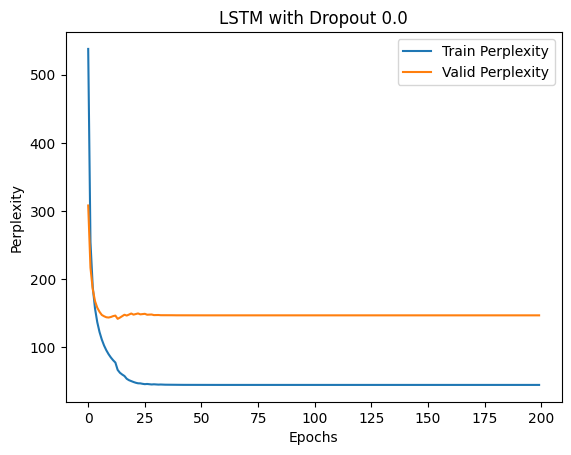


Training GRU with Dropout=0.0
Epoch 1, Train Perplexity: 468.84, Valid Perplexity: 252.26, Learning Rate: 5.0000
Epoch 2, Train Perplexity: 212.82, Valid Perplexity: 189.06, Learning Rate: 5.0000
Epoch 3, Train Perplexity: 158.45, Valid Perplexity: 168.90, Learning Rate: 5.0000
Epoch 4, Train Perplexity: 130.08, Valid Perplexity: 159.45, Learning Rate: 5.0000
Epoch 5, Train Perplexity: 111.49, Valid Perplexity: 159.22, Learning Rate: 5.0000
Epoch 6, Train Perplexity: 98.26, Valid Perplexity: 159.97, Learning Rate: 5.0000
Epoch 7, Train Perplexity: 88.72, Valid Perplexity: 162.62, Learning Rate: 5.0000
Epoch 8, Train Perplexity: 81.71, Valid Perplexity: 164.74, Learning Rate: 2.5000
Epoch 9, Train Perplexity: 65.28, Valid Perplexity: 153.75, Learning Rate: 2.5000
Epoch 10, Train Perplexity: 59.80, Valid Perplexity: 157.63, Learning Rate: 2.5000
Epoch 11, Train Perplexity: 56.36, Valid Perplexity: 162.04, Learning Rate: 2.5000
Epoch 12, Train Perplexity: 53.56, Valid Perplexity: 166.54,

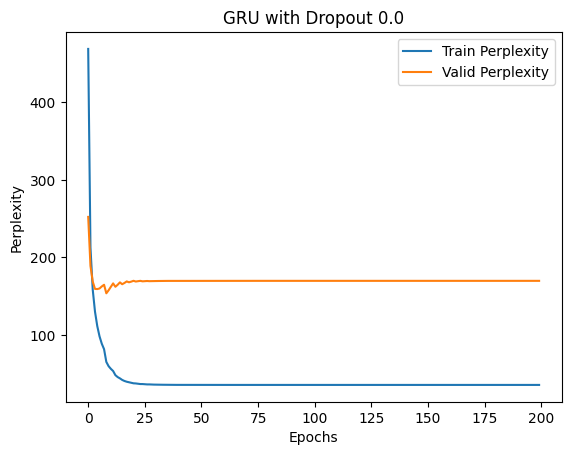


Training LSTM with Dropout=0.25
Epoch 1, Train Perplexity: 573.16, Valid Perplexity: 322.49, Learning Rate: 5.0000
Epoch 2, Train Perplexity: 287.83, Valid Perplexity: 225.43, Learning Rate: 5.0000
Epoch 3, Train Perplexity: 219.86, Valid Perplexity: 189.84, Learning Rate: 5.0000
Epoch 4, Train Perplexity: 188.18, Valid Perplexity: 171.38, Learning Rate: 5.0000
Epoch 5, Train Perplexity: 168.90, Valid Perplexity: 159.28, Learning Rate: 5.0000
Epoch 6, Train Perplexity: 155.60, Valid Perplexity: 151.24, Learning Rate: 5.0000
Epoch 7, Train Perplexity: 145.78, Valid Perplexity: 145.21, Learning Rate: 5.0000
Epoch 8, Train Perplexity: 138.08, Valid Perplexity: 139.51, Learning Rate: 5.0000
Epoch 9, Train Perplexity: 131.90, Valid Perplexity: 136.03, Learning Rate: 5.0000
Epoch 10, Train Perplexity: 126.90, Valid Perplexity: 133.15, Learning Rate: 5.0000
Epoch 11, Train Perplexity: 122.46, Valid Perplexity: 130.46, Learning Rate: 5.0000
Epoch 12, Train Perplexity: 119.04, Valid Perplexity

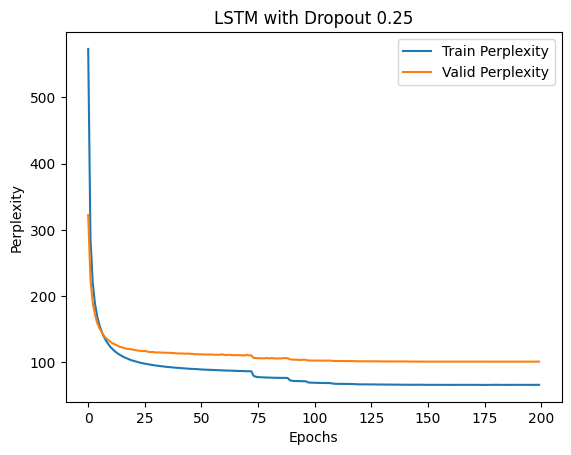


Training GRU with Dropout=0.28
Epoch 1, Train Perplexity: 513.69, Valid Perplexity: 270.07, Learning Rate: 5.0000
Epoch 2, Train Perplexity: 259.92, Valid Perplexity: 206.89, Learning Rate: 5.0000
Epoch 3, Train Perplexity: 208.26, Valid Perplexity: 179.92, Learning Rate: 5.0000
Epoch 4, Train Perplexity: 183.45, Valid Perplexity: 165.32, Learning Rate: 5.0000
Epoch 5, Train Perplexity: 167.68, Valid Perplexity: 158.05, Learning Rate: 5.0000
Epoch 6, Train Perplexity: 157.02, Valid Perplexity: 151.94, Learning Rate: 5.0000
Epoch 7, Train Perplexity: 149.07, Valid Perplexity: 145.37, Learning Rate: 5.0000
Epoch 8, Train Perplexity: 142.93, Valid Perplexity: 145.08, Learning Rate: 5.0000
Epoch 9, Train Perplexity: 138.46, Valid Perplexity: 140.92, Learning Rate: 5.0000
Epoch 10, Train Perplexity: 134.69, Valid Perplexity: 139.18, Learning Rate: 5.0000
Epoch 11, Train Perplexity: 131.57, Valid Perplexity: 137.41, Learning Rate: 5.0000
Epoch 12, Train Perplexity: 128.77, Valid Perplexity:

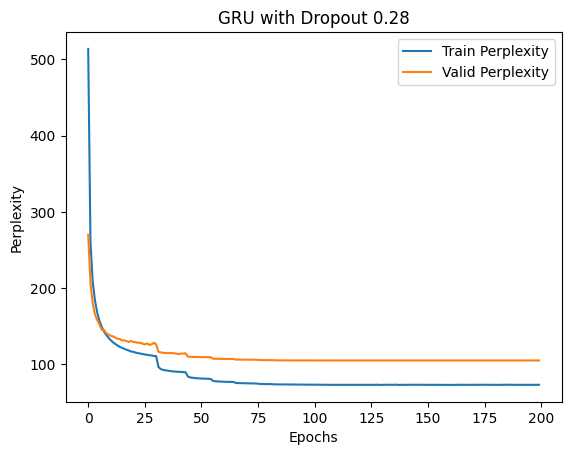

   Type  Dropout  Final Train Perplexity  Min Valid Perplexity
0  LSTM      0.0               44.927288            141.883682
1   GRU      0.0               35.624584            153.749344
2  LSTM     0.25               65.986412            100.968788
3   GRU     0.28               73.278214            105.100021

   Test Perplexity at Min  
0             139.784563  
1             96.924879  
2             157.201789  
3             101.854321  


In [8]:
# Executing training
results = []
for config in configs:
    print(f"\nTraining {config.cell_type} with Dropout={config.dropout}")
    train_loader = get_data_loader(train_data, batch_size=config.batch_size, seq_len=config.seq_len)
    valid_loader = get_data_loader(valid_data, batch_size=config.batch_size, seq_len=config.seq_len)
    test_loader = get_data_loader(test_data, batch_size=config.batch_size, seq_len=config.seq_len)
    model = RNNModel(vocab_size=vocab_size, hidden_size=config.hidden_size,
                     num_layers=config.num_layers, dropout=config.dropout, model_type=config.cell_type)
    train_perps, valid_perps, test_perp = train_model(model, train_loader, valid_loader, test_loader, config)
    plt.figure()
    plt.plot(train_perps, label='Train Perplexity')
    plt.plot(valid_perps, label='Valid Perplexity')
    plt.title(f'{config.cell_type} with Dropout {config.dropout}')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()
    min_valid_perp = min(valid_perps)
    test_perp_at_min = test_perp
    results.append((config.cell_type, config.dropout, train_perps[-1], min_valid_perp, test_perp_at_min))

results_df = pd.DataFrame(results, columns=['Type', 'Dropout', 'Final Train Perplexity', 'Min Valid Perplexity', 'Test Perplexity at Min'])
print(results_df)
results_df.to_csv('model_perplexities.csv', index=False)

In [9]:
# Loading the models
# LSTM with Dropout=0.0
model = RNNModel(vocab_size=vocab_size, hidden_size=200, num_layers=2, dropout=0.0, model_type='LSTM')
model.load_state_dict(torch.load('best_model_LSTM_dropout0.0.pth'))
model.to(device)

In [ ]:
# LSTM with Dropout=0.25
model = RNNModel(vocab_size=vocab_size, hidden_size=200, num_layers=2, dropout=0.25, model_type='LSTM')
model.load_state_dict(torch.load('best_model_LSTM_dropout0.25.pth'))
model.to(device)

In [ ]:
# GRU with Dropout=0.0
model = RNNModel(vocab_size=vocab_size, hidden_size=200, num_layers=2, dropout=0.0, model_type='GRU')
model.load_state_dict(torch.load('best_model_GRU_dropout0.0.pth'))
model.to(device)

In [ ]:
# GRU with Dropout=0.28
model = RNNModel(vocab_size=vocab_size, hidden_size=200, num_layers=2, dropout=0.28, model_type='GRU')
model.load_state_dict(torch.load('best_model_GRU_dropout0.28.pth'))
model.to(device)